In [1]:
from fastai import *
from fastai.vision import *
import time

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Download and check images

In [3]:
folders = {'phalaenopsis':'phalaenopsis.txt', 
           'catasetum':'catasetum.txt',
           'cattleya':'cattleya.txt',
           'dendrobium':'dendrobium.txt',
           'vanda':'vanda.txt'}

In [3]:
def get_data(folder, filename, n_max=200):
    path = Path('./data/')
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(path/filename, dest, max_pics=n_max, max_workers=4)

In [ ]:
#for folder, filename in folders.items():
#    get_data(folder, filename, 500)
#    time.sleep(3)

In [4]:
classes = list(folders.keys())
path = Path('./data/')

In [5]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

phalaenopsis


catasetum


cattleya


dendrobium


vanda


### Create dataset and train classifier

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

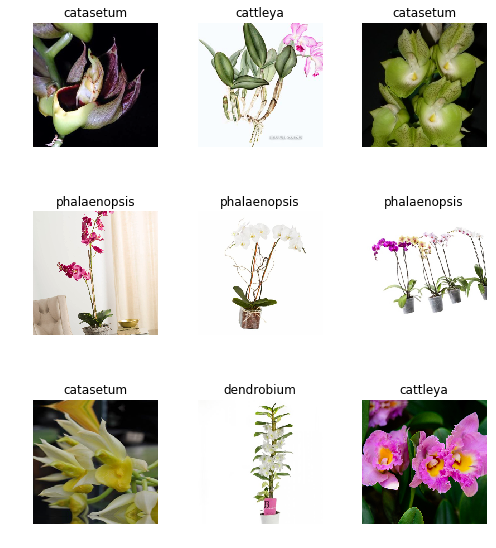

In [6]:
data.show_batch(rows=3, figsize=(7,8))

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['catasetum', 'cattleya', 'dendrobium', 'phalaenopsis', 'vanda'],
 5,
 1580,
 428)

In [6]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [9]:
learn.fit_one_cycle(5)

Total time: 02:10
epoch  train_loss  valid_loss  error_rate
1      1.313902    0.553490    0.207944    (00:25)
2      0.847441    0.340385    0.133178    (00:26)
3      0.614573    0.280127    0.107477    (00:26)
4      0.480317    0.277827    0.102804    (00:27)
5      0.393408    0.272439    0.095794    (00:24)



In [10]:
learn.save('./stage-1')

In [18]:
learn.load('./stage-1')

In [19]:
learn.unfreeze()

In [12]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


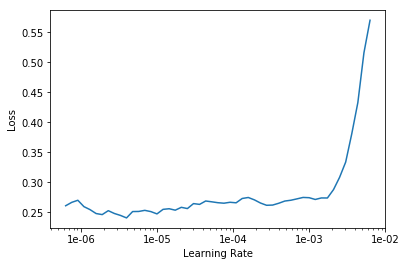

In [13]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(4, max_lr=slice(2e-5, 2e-4))

Total time: 01:49
epoch  train_loss  valid_loss  error_rate
1      0.264154    0.248587    0.086449    (00:27)
2      0.205959    0.197301    0.074766    (00:26)
3      0.159237    0.177164    0.065421    (00:27)
4      0.120716    0.170244    0.060748    (00:27)



In [27]:
learn.save('./stage-2')

In [7]:
learn.load('stage-2')

In [8]:
interp = ClassificationInterpretation.from_learner(learn)

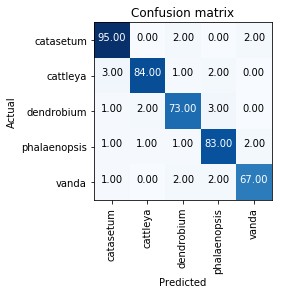

In [9]:
interp.plot_confusion_matrix()

In [10]:
losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [ ]:
#from fastai.widgets import *

In [ ]:
## Delete images that don't belong to the dataset
#fd = FileDeleter(file_paths=top_loss_paths)

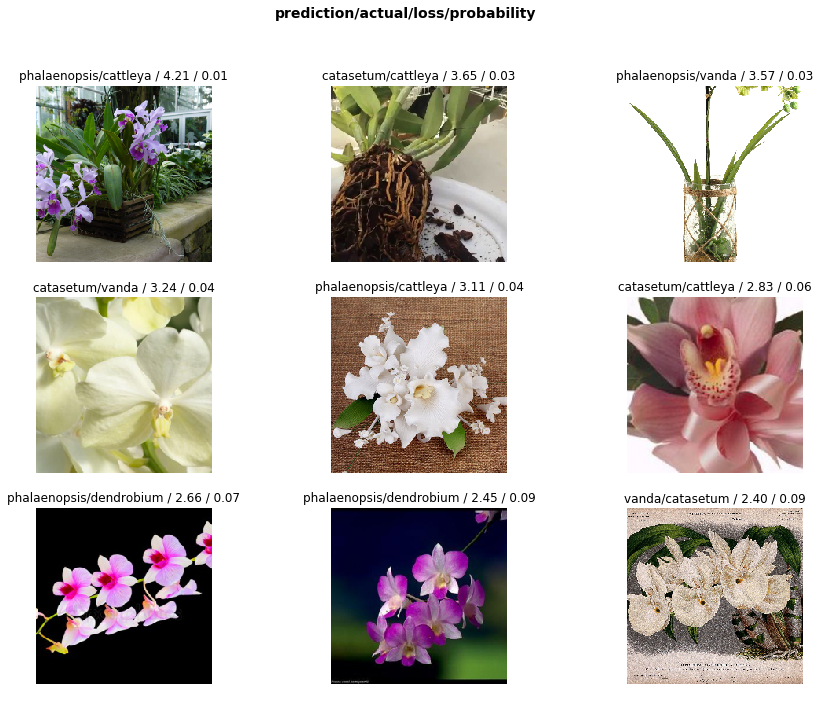

In [11]:
interp.plot_top_losses(9, figsize=(15,11))

### Plot incorrectly classified images

In [16]:
import numpy as np

In [35]:
## Get indexes of incorrectly classified images
wrong_idxs = np.where(interp.pred_class != interp.y_true)[0]

In [56]:
len(wrong_idxs)

26

In [71]:
def plot_incorrect(k, largest=True, figsize=(12,12)):
    wr_idx = np.random.choice(wrong_idxs, k, replace=False)
    rows = math.ceil(math.sqrt(k))
    fig,axes = plt.subplots(rows,rows,figsize=figsize)
    fig.suptitle('prediction/actual', weight='bold', size=14)
    for i,idx in enumerate(wr_idx):
        t=data.valid_ds[idx]
        t[0].show(ax=axes.flat[i], title=
            f'{data.classes[interp.pred_class[idx]]}/{data.classes[interp.y_true[idx]]}')

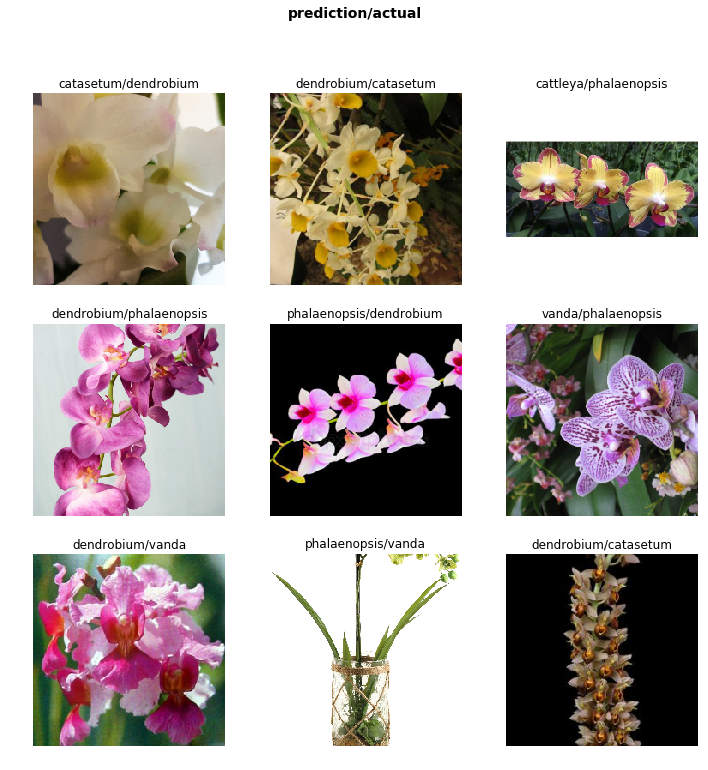

In [72]:
plot_incorrect(9)

### Models

In [60]:
!ls -l ./data/models/

total 170672
-rw-r--r-- 1 jupyter jupyter 87381294 Nov  6 19:21 stage-1.pth
-rw-r--r-- 1 jupyter jupyter 87381294 Nov  6 19:30 stage-2.pth
